<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> Tarea 3 - Ensamblados y modelos avanzados</h1>

<H3 align='center'> <i>Felipe Olavarria, Rol:201673606-9</i> </H3>
<H3 align='center'> <i>Jean Aravena, Rol:201673573-9</i> </H3>
<hr style="height:2px;border:none"/>

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Ensamblados para regresión
Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.


>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.

In [5]:
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

In [6]:
df.head(5)

,date,meantemp,humidity,wind_speed,meanpressure,y_value
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.400000
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,7.166667
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,6.000000
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.000000


> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.

In [7]:
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
#df.drop(["date"], axis=1, inplace=True) #delete date
params = ['meantemp','humidity','wind_speed','meanpressure','y_value']
cols = ['meantemp','humidity','wind_speed','meanpressure','y_value','cday','year','month','season_fall','season_rainy','season_summer','season_winter']
df[cols].head(5)

,meantemp,humidity,wind_speed,meanpressure,y_value,cday,year,month,season_fall,season_rainy,season_summer,season_winter
0,10.000000,84.500000,0.000000,1015.666667,7.400000,1,2013,1,0,0,0,1
1,7.400000,92.000000,2.980000,1017.800000,7.166667,2,2013,1,0,0,0,1
2,7.166667,87.000000,4.633333,1018.666667,8.666667,3,2013,1,0,0,0,1
3,8.666667,71.333333,1.233333,1017.166667,6.000000,4,2013,1,0,0,0,1
4,6.000000,86.833333,3.700000,1016.500000,7.000000,5,2013,1,0,0,0,1


***En base a la fecha no existe mayor información que sea relevante respecto al problema.***

> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.

In [8]:
y = df[cols].pop("y_value").values
X = df[cols].values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.

In [11]:
df.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure', 'y_value',
       'cday', 'year', 'month', 'season_fall', 'season_rainy', 'season_summer',
       'season_winter'],
      dtype='object')

In [12]:
df.shape

(1461, 13)

***Tenemos 1461 datos diferentes en el dataset, cada uno con 13 atributos. Date lo dejamos para poder graficar las caracteristicas meantemp, humidity, wind_speed y meanpressure.***

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 13 columns):
date             1461 non-null datetime64[ns]
meantemp         1461 non-null float64
humidity         1461 non-null float64
wind_speed       1461 non-null float64
meanpressure     1461 non-null float64
y_value          1461 non-null float64
cday             1461 non-null int64
year             1461 non-null int64
month            1461 non-null int64
season_fall      1461 non-null uint8
season_rainy     1461 non-null uint8
season_summer    1461 non-null uint8
season_winter    1461 non-null uint8
dtypes: datetime64[ns](1), float64(5), int64(3), uint8(4)
memory usage: 108.5 KB


***Se muestra el resumen del dataframe, en el cual no existen registros nulos para ninguna de las 13 columnas.
Además se informa el tipo de dato que presenta cada una de los atributos y la memoria utilizada.***

In [10]:
df[params].describe()

,meantemp,humidity,wind_speed,meanpressure,y_value
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,25.506127,60.744851,6.806865,1011.101197,25.506127
std,7.339416,16.743928,4.559688,180.293335,7.339416
min,6.000000,13.428571,0.000000,-3.041667,6.000000
25%,18.857143,50.375000,3.475000,1001.571429,18.857143
50%,27.714286,62.625000,6.250000,1008.555556,27.714286
75%,31.312500,72.125000,9.250000,1014.937500,31.312500
max,38.714286,98.000000,42.220000,7679.333333,38.714286


***Las mediciones del dataset corresponden a un período de 4 años (2013-2017). El método df.describe() genera estadísticas descriptivas del dataframe en cuestión. Se informa el valor promedio, dispersión y la forma de la distribución de los datos según atributo, donde cabe destacar que la presión muestra un máximo y minimo muy anormales respecto a la media,7679.33 y -3.04 respectivamente. El valor medio de la presión de la atmósfera terrestre es de 1013.25 __[[1]](https://es.wikipedia.org/wiki/Presi%C3%B3n_atmosf%C3%A9rica#cite_note-2)__, lo que significa o que hubo alguna anomalia climatica o errores en la medición de la presión.***

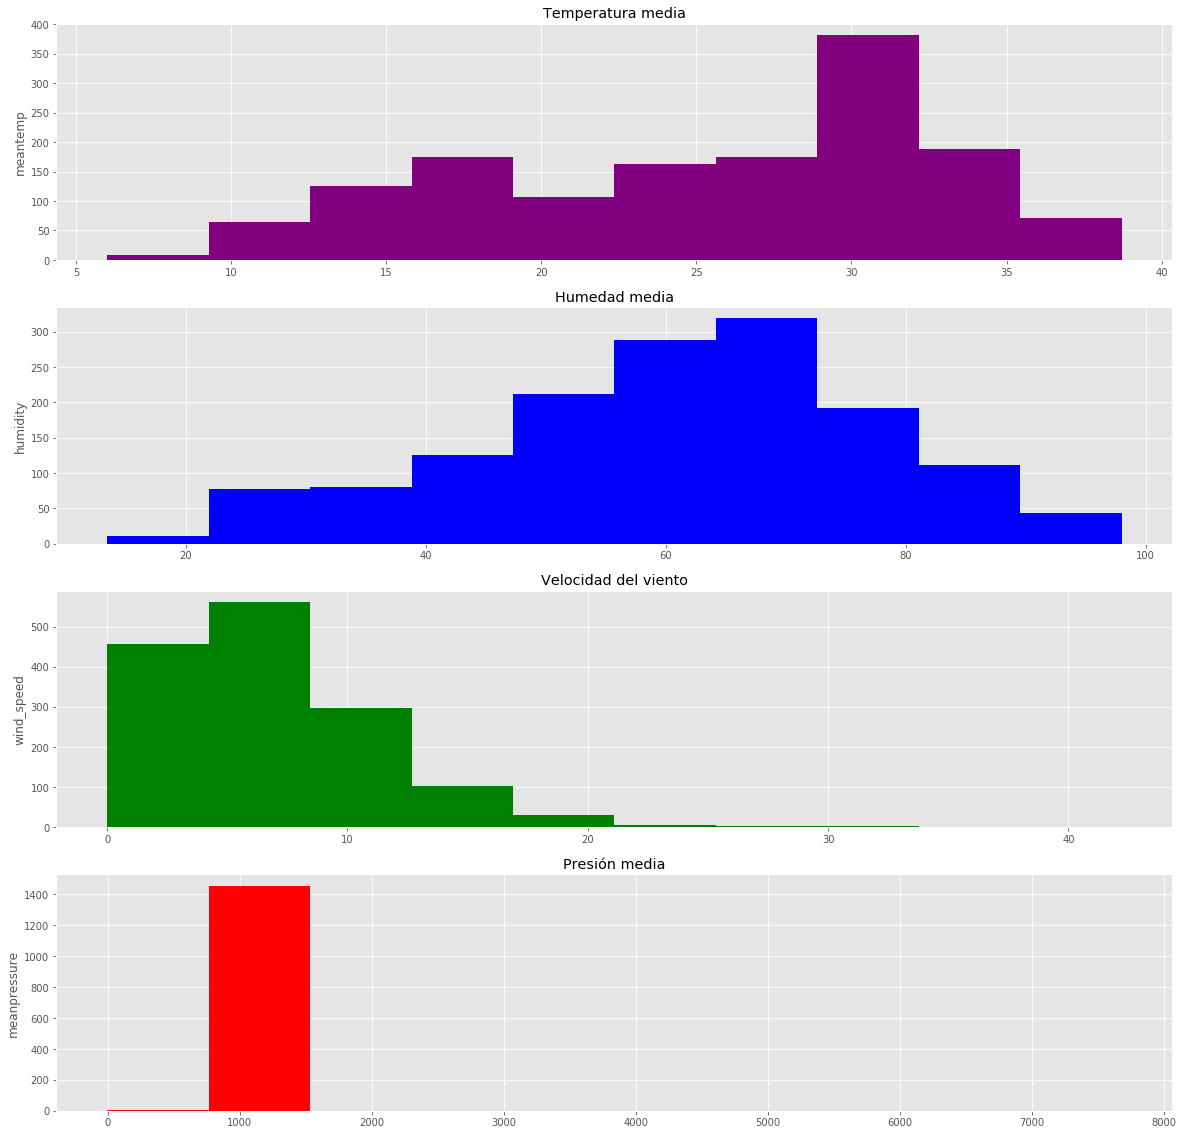

In [81]:
plt.style.use('ggplot')
plt.figure(figsize=(20,20))


plt.subplot(411)
plt.hist(df['meantemp'],color='purple')
plt.ylabel("meantemp")
plt.title('Temperatura media')


plt.subplot(412)
plt.hist(df['humidity'],color='blue')
plt.ylabel("humidity")
plt.title('Humedad media')

plt.subplot(413)
plt.hist(df['wind_speed'],color='green')
plt.ylabel("wind_speed")
plt.title('Velocidad del viento')

plt.subplot(414)
plt.hist(df['meanpressure'],color='red')
plt.ylabel("meanpressure")
plt.title('Presión media')

plt.show()

***Se muestra la distribución de los parámetros ambientales. Se puede apreciar los outliers en la presión anteiormente mencionados. Para su mejor comprensión se incluiran visualizaciones sin esta data en adelante. De los parámetros se puede comentar que cada uno tiene su propio sesgo y se distribuye relativamente normal respecto a este. La presión sin outliers por su parte sigue siendo el dato más atípico en el dataframe.***

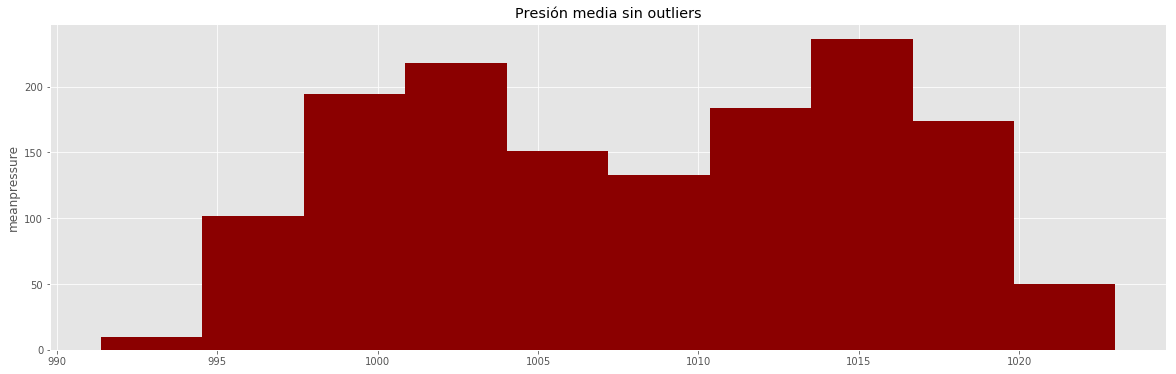

In [87]:
plt.figure(figsize=(20,6))
plt.hist(df[(np.abs(stats.zscore(df['meanpressure'])) < 0.2)]['meanpressure'],color='darkred')
plt.ylabel("meanpressure")
plt.title('Presión media sin outliers')
plt.show()


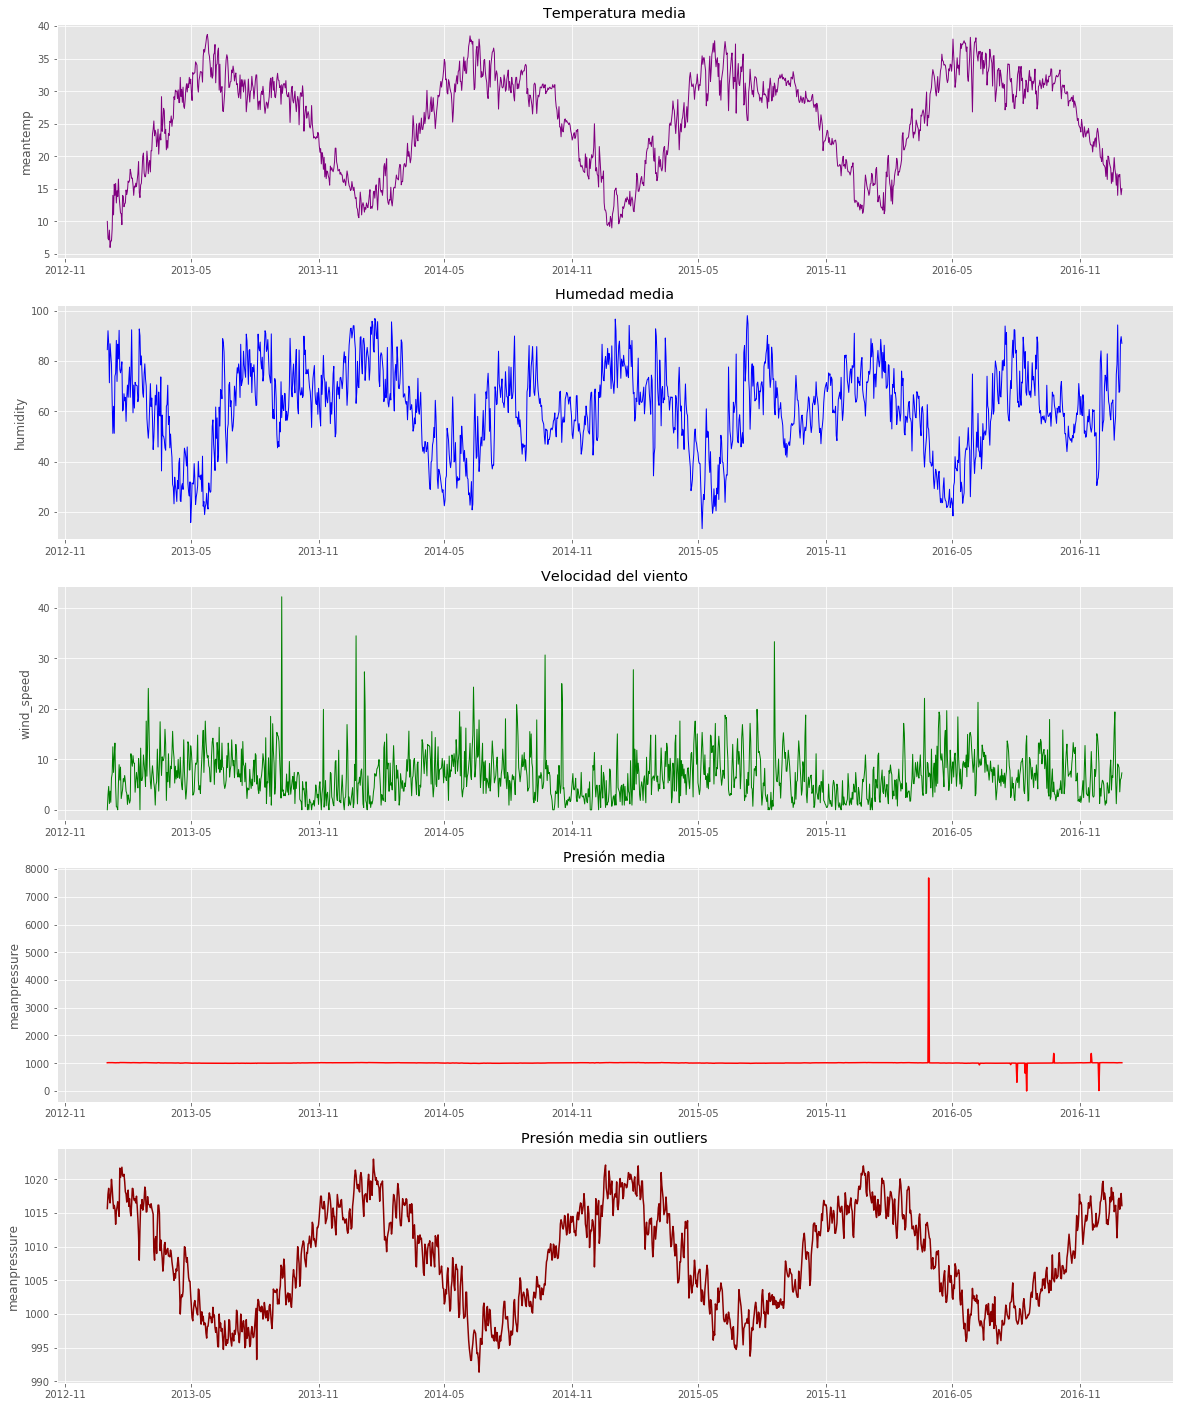

In [109]:
plt.figure(figsize=(20,25))


plt.subplot(511)
plt.plot(df['date'], df['meantemp'],c='purple',linewidth=1)
plt.ylabel("meantemp")
plt.title('Temperatura media')


plt.subplot(512)
plt.plot(df['date'], df['humidity'],c='blue',linewidth=1)
plt.ylabel("humidity")
plt.title('Humedad media')

plt.subplot(513)
plt.plot(df['date'], df['wind_speed'],c='green',linewidth=1)
plt.ylabel("wind_speed")
plt.title('Velocidad del viento')

plt.subplot(514)
plt.plot(df['date'], df['meanpressure'],c='red')
plt.ylabel("meanpressure")
plt.title('Presión media')

plt.subplot(515)
plt.plot(df[(np.abs(stats.zscore(df['meanpressure'])) < 0.2)]['date'], df[(np.abs(stats.zscore(df['meanpressure'])) < 0.2)]['meanpressure'],c='darkred')
plt.ylabel("meanpressure")
plt.title('Presión media sin outliers')

plt.show()

***De las series de tiempo se puede rescatar la estacionalidad de la data, por lo que si sera relevante y aportara al problema agregar esta información al modelo. Pese a la estacionalidad de esta, la tendencia puede variar considerablemente de un día a otro. En el caso de la temperatura en promedio hay margenes de cinco grados, lo que es relevante para la persona que mira el pronostico diario del tiempo. El viento es el que muestra más variante pero aún así se puede ver una media movil a traves del año.***

In [123]:
#dummy df para rescalar datos y comparar las distintas escalas
dummy = df[params+['month','year']].copy()
#agrupar por mes y año
dummy = dummy.groupby(['year','month']).mean().reset_index()
for para in params:
    dummy[para] = (dummy[para]-dummy[para].min())/(dummy[para].max()-dummy[para].min())
dummy['date'] = dummy['year'].astype(str) +'-'+dummy['month'].astype(str)
dummy["date"] = pd.to_datetime(dummy["date"])

#hacer lo mismo para la presión sin outliers

pressure_2 = df[(np.abs(stats.zscore(df['meanpressure'])) < 0.3)][['year','month','meanpressure','meantemp']]
pressure_2 = pressure_2.groupby(['year','month']).mean().reset_index()
pressure_2['meanpressure'] = (pressure_2['meanpressure']-pressure_2['meanpressure'].min())/(pressure_2['meanpressure'].max()-pressure_2['meanpressure'].min())
pressure_2['date'] = pressure_2['year'].astype(str) +'-'+pressure_2['month'].astype(str)
pressure_2["date"] = pd.to_datetime(dummy["date"])


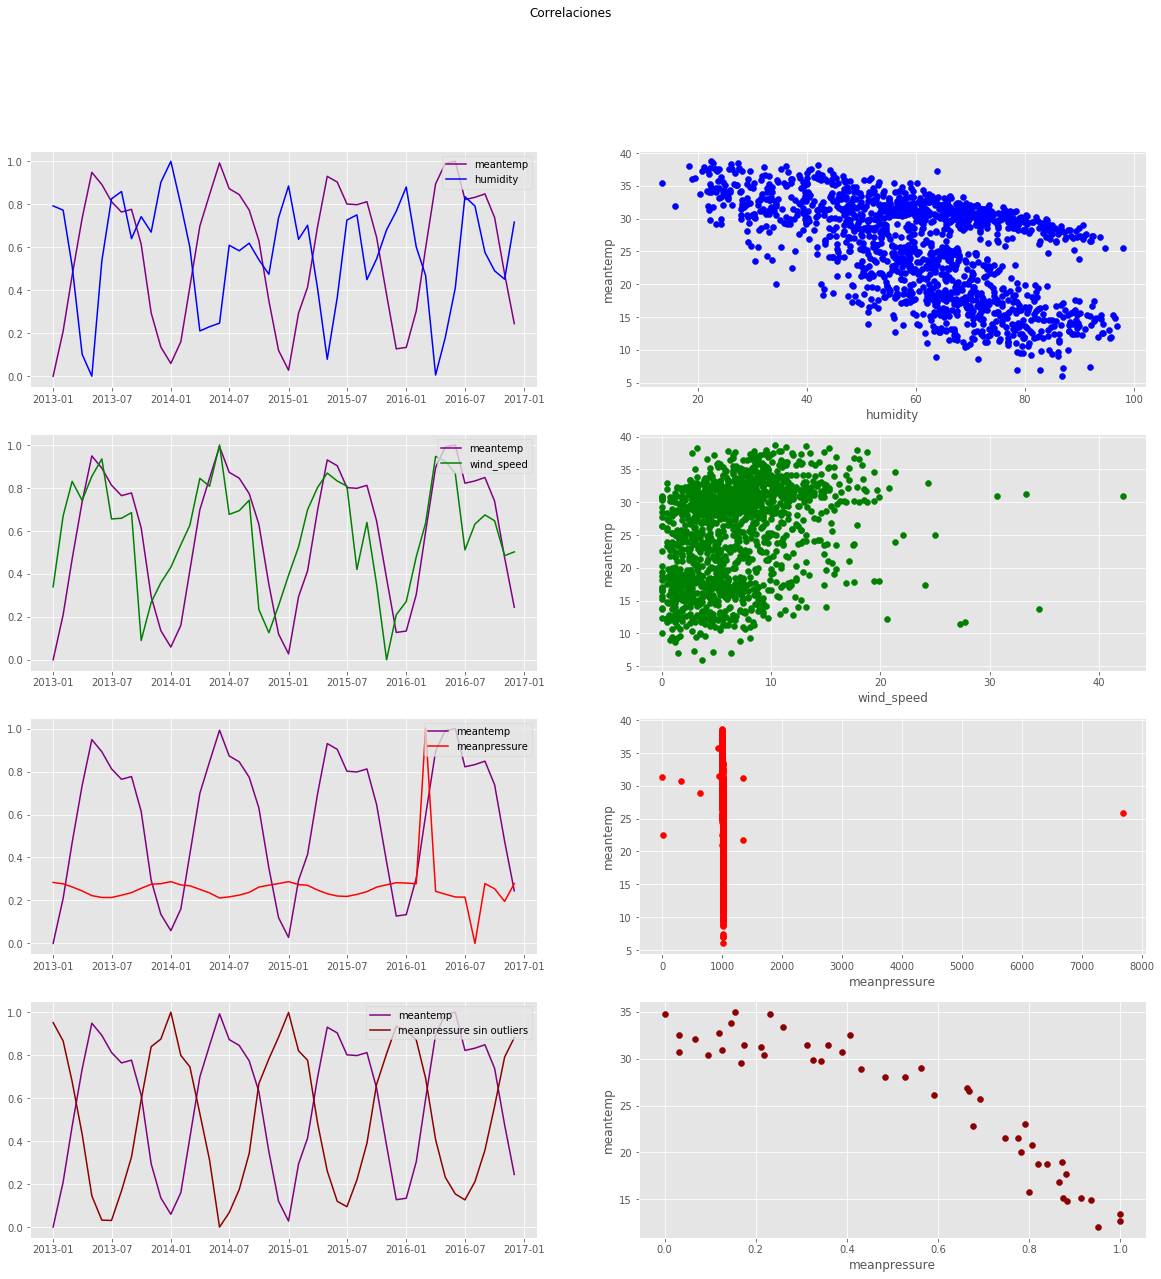

In [150]:
#plot by month,year
plt.figure(figsize=(20,20))
plt.suptitle('Correlaciones')

plt.subplot(421)
plt.plot(dummy['date'], dummy['meantemp'],c='purple')
plt.plot(dummy['date'], dummy['humidity'],c='blue')
plt.legend(loc='upper right')

plt.subplot(422)
plt.scatter(df['humidity'], df['meantemp'],c='blue')
plt.xlabel("humidity")
plt.ylabel("meantemp")


plt.subplot(423)
plt.plot(dummy['date'], dummy['meantemp'],c='purple')
plt.plot(dummy['date'], dummy['wind_speed'],c='green')
plt.legend(loc='upper right')

plt.subplot(424)
plt.scatter(df['wind_speed'], df['meantemp'],c='green')
plt.xlabel("wind_speed")
plt.ylabel("meantemp")


plt.subplot(425)
plt.plot(dummy['date'], dummy['meantemp'],c='purple')
plt.plot(dummy['date'], dummy['meanpressure'],c='red')
plt.legend(loc='upper right')

plt.subplot(426)
plt.scatter(df['meanpressure'], df['meantemp'],c='red')
plt.xlabel("meanpressure")
plt.ylabel("meantemp")


plt.subplot(427)
plt.plot(dummy['date'], dummy['meantemp'],c='purple')
plt.plot(pressure_2['date'], pressure_2['meanpressure'],c='darkred',label='meanpressure sin outliers')
plt.legend(loc='upper right')

plt.subplot(428)
plt.scatter(pressure_2['meanpressure'], pressure_2['meantemp'],c='darkred')
plt.xlabel("meanpressure")
plt.ylabel("meantemp")



plt.show()


***Los gráficos de la izquierda muestran el promedio mensual de cada párametro con el objetivo de eliminar el ruido, se normalizan de 0 a 1, y se comparan con la temperatura del día (que es el dato que supuestamente esta más cercano al que se quiere predecir, el del día siguiente). Así se captura el movimiento promedio en cada estación. A la derecha esta la relación directa atemporal entre las variables.***

***De los gráficos se rescata, generalmente, una corelación positiva entre la temperatura y el nivel del viento. Es decir a mayor velocidad del viento mayor temperatura. Y en general una negativa entre la presión del aire y la humedad. En el caso de la presión queda de manera más clara, donde cada máximo de temperatura coincide con el mínimo de presión, independiente de la fecha.***

***Las diferencias en estos comportamientos que se ven en la serie de tiempo se pueden atribuir a las distintas estaciones, por lo que no hay que presumir una causalidad total entre estas variables. Sin embargo, se puede concluir que se esta incorporando información relevante adicional a un modelo si no solo se toma en cuenta la información del día anterior. Siempre y cuando se encuentre relativamente cerca de la ventana estacional, dado que existe mucho ruido fuera de ellas.***

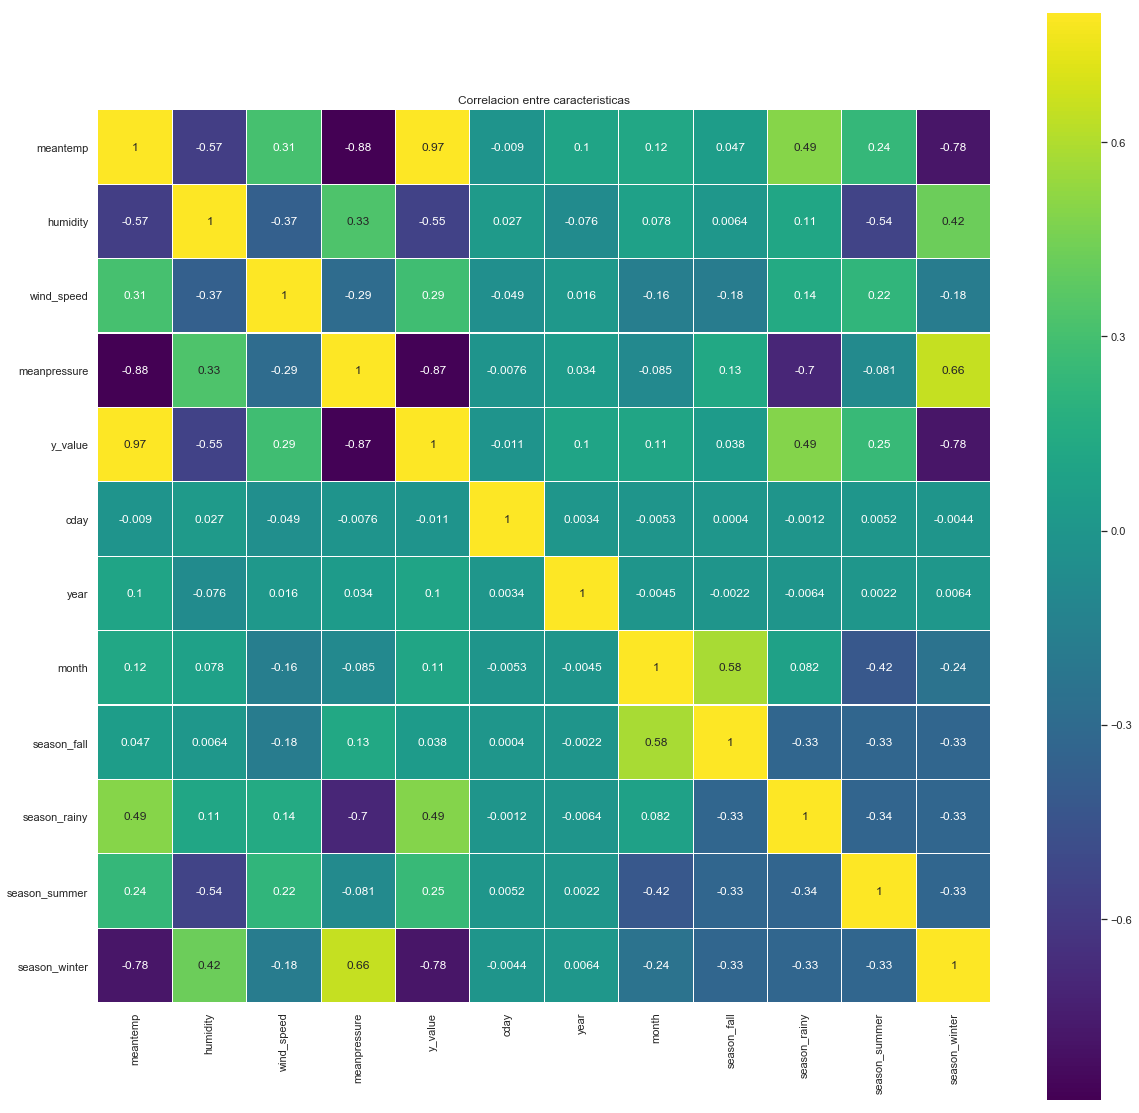

In [154]:
plt.figure(figsize=(20,20))
sns.heatmap(df[(np.abs(stats.zscore(df['meanpressure'])) < 0.3)].corr(), vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
sns.set(font_scale=1)
plt.title('Correlacion entre caracteristicas');
plt.show()

***Finalmente se muestran todas las correlaciones entre los atributos, se puede corroborar que además de los cuatro parámetros iniciales, las estaciones otorgan información valiosa para el valor de la temperatura. Siendo la data de las fechas en sí las menos correlacionadas, con el día de la semana la menos relevante.***

> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?

In [15]:
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [16]:
#Proceso para regularizar el modelo
def do_Tree(x,y,xv,yv, param_d=None, param_m=2):
    model= Tree()
    #print("Param Max-D= ",param_d, 'Min-samples-S= ', param_m)
    model.set_params(max_depth=param_d, min_samples_split=param_m) 
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Depths = np.arange(1,300, 10) #choose steps
SamplesS = np.arange(2, X_train.shape[0] , 10 ) #choose steps

ltrain = np.zeros(shape=(Depths.shape[0],SamplesS.shape[0])) 
ltest  = np.zeros(shape=(Depths.shape[0],SamplesS.shape[0])) 
for i in range(Depths.shape[0]):
    for j in range(SamplesS.shape[0]):
        model, train_acc, test_acc = do_Tree(X_train,y_train,X_val,y_val, param_d = Depths[i], param_m=SamplesS[j])
        ltrain[i][j] = train_acc
        ltest[i][j]  = test_acc

Máximo test_acc: 0.9999, Max depth óptimo: 81 Min samples óptimo: 2
	 train_acc: 1.0


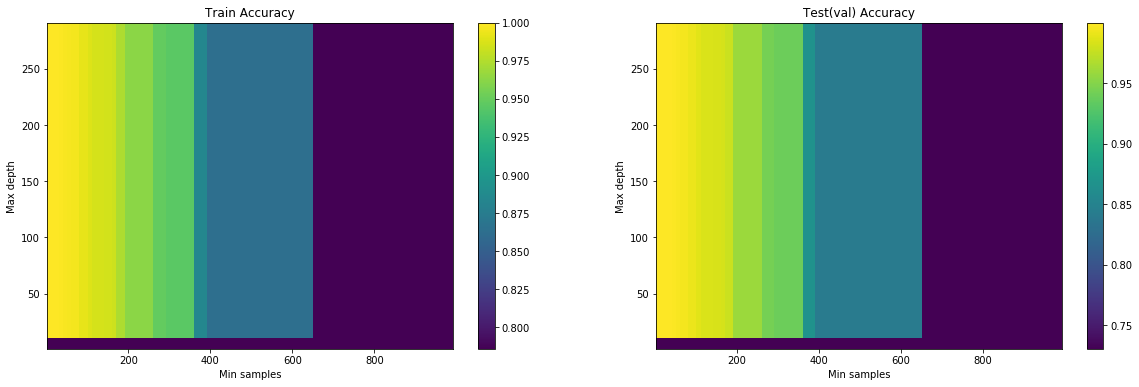

In [17]:
%matplotlib inline
#test = np.asarray(zs_train,).reshape(200,200)
#print(len(xs_train))

plt.figure(figsize=(20,6))

plt.subplot(121)
plt.pcolormesh(SamplesS,Depths,ltrain)#,vmin=0, vmax=1)
plt.title("Train Accuracy")
plt.xlabel("Min samples")
plt.ylabel("Max depth")
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(SamplesS,Depths,ltest)#,vmin=0, vmax=1)
plt.title("Test(val) Accuracy")
plt.xlabel("Min samples")
plt.ylabel("Max depth")
plt.colorbar()

m = -1
k = -1
l = -1

for i in range(Depths.shape[0]):
    for j in range(SamplesS.shape[0]):
        if ltest[i][j] > m:
            m = ltest[i][j]
            k = i
            l = j

print("Máximo test_acc: "+str(round(m,4)) + ", Max depth óptimo: "+ str(round(Depths[k],4)) + " Min samples óptimo: "+ str(round(SamplesS[l],4)))
print("\t train_acc: "+str(round(ltrain[k][l],4)))

In [18]:
#Modelo regularizado
model = Tree(max_depth=81,min_samples_split=2)
model.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=81, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

***comentar weas que piden***

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica Root Mean Squared Error (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización vs el no regularizar.

RMSE train (Modelo regularizado)=  4.766465574234764e-16
RMSE val (Modelo regularizado)=  0.06191914463864411

RMSE train (Modelo no regularizado)=  4.766465574234764e-16
RMSE val (Modelo no regularizado)=  0.06248854225514321


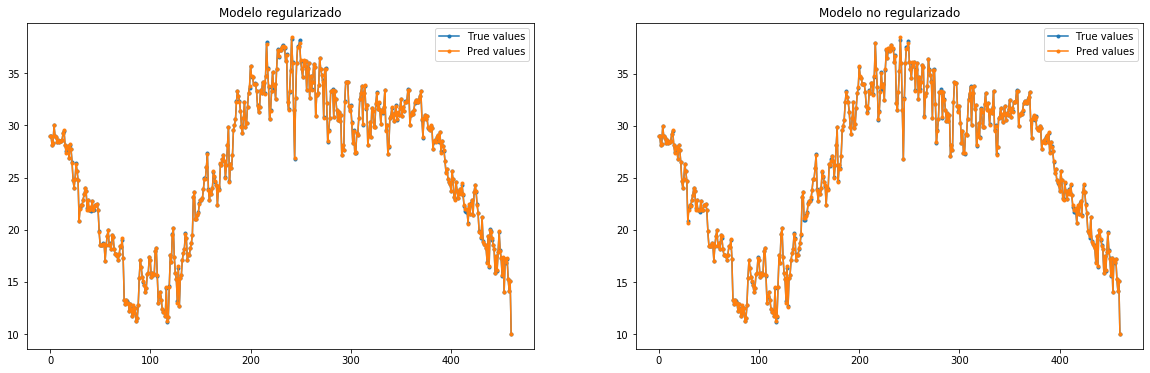

In [19]:
#Modelo regularizado
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)
print("RMSE train (Modelo regularizado)= ",RMSE(y_train,y_train_hat))
print("RMSE val (Modelo regularizado)= ",RMSE(y_val,y_val_hat))

plt.figure(figsize=(20,6))

plt.subplot(121)
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.title('Modelo regularizado')
plt.legend()

#Modelo no regularizado
y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("\nRMSE train (Modelo no regularizado)= ",RMSE(y_train,y_train_hat))
print("RMSE val (Modelo no regularizado)= ",RMSE(y_val,y_val_hat))

plt.subplot(122)
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.title('Modelo no regularizado')
plt.legend()

***comentar weas que piden***.

> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de Bagging, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en b)) ¿Qué debería suceder? ¿Se visualiza overfitting? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

In [32]:
from sklearn.ensemble import BaggingRegressor

#Modelo regularizado
rmse_train_r=[]
rmse_val_r=[]

N_estimators=range(1,200,2)

for i in N_estimators:
    model = BaggingRegressor(base_estimator=Tree(max_depth=81,min_samples_split=2), n_estimators=i, n_jobs=-1)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train_r.append(RMSE(y_train,y_train_hat))
    rmse_val_r.append(RMSE(y_val,y_val_hat))

#Modelo mo regularizado
rmse_train=[]
rmse_val=[]

for i in N_estimators:
    model = BaggingRegressor(base_estimator=Tree(), n_estimators=i, n_jobs=-1)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train.append(RMSE(y_train,y_train_hat))
    rmse_val.append(RMSE(y_val,y_val_hat))

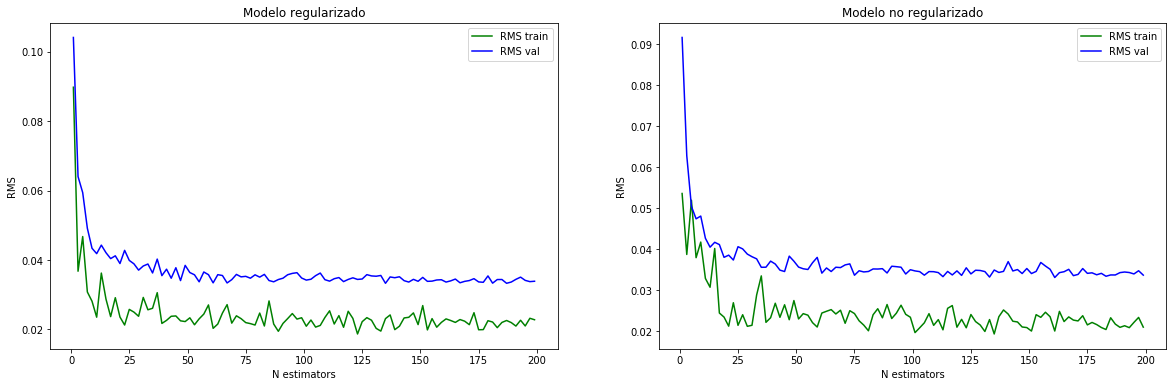

In [34]:
plt.figure(figsize=(20,6))

#Modelo regularizado
plt.subplot(121)
plt.plot(N_estimators, rmse_train_r, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val_r, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo regularizado')
plt.legend()

#Modelo no regularizado
plt.subplot(122)
plt.plot(N_estimators, rmse_train, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo no regularizado')
plt.legend()

***comentar weas.***

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de AdaBoost, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en d) ¿Se visualiza overfitting? ¿Qué técnica utiliza la librería de sklearn, re-muestrear o pesar ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).

In [36]:
from sklearn.ensemble import AdaBoostRegressor

#Modelo regularizado
rmse_train_r=[]
rmse_val_r=[]

N_estimators=range(1,200,2)

for i in N_estimators:
    model = AdaBoostRegressor(base_estimator=Tree(max_depth=81,min_samples_split=2), n_estimators=i)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train_r.append(RMSE(y_train,y_train_hat))
    rmse_val_r.append(RMSE(y_val,y_val_hat))

#Modelo mo regularizado
rmse_train=[]
rmse_val=[]

for i in N_estimators:
    model = AdaBoostRegressor(base_estimator=Tree(), n_estimators=i)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train.append(RMSE(y_train,y_train_hat))
    rmse_val.append(RMSE(y_val,y_val_hat))

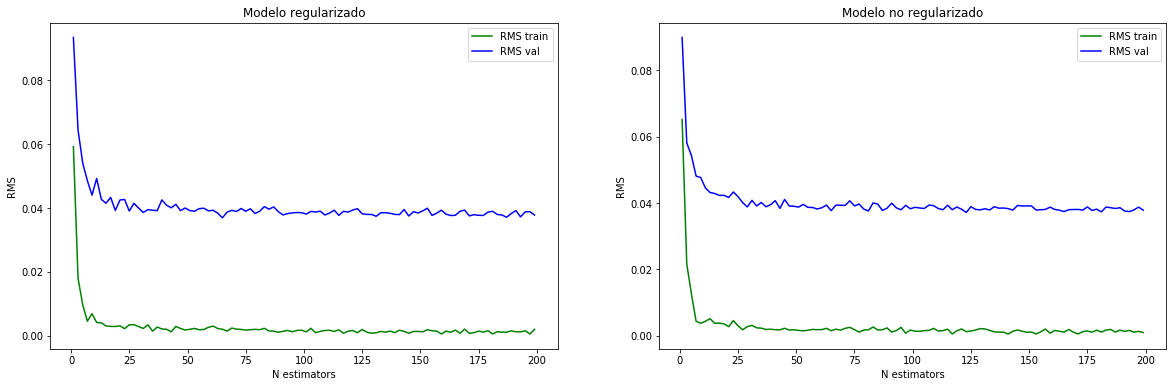

In [37]:
plt.figure(figsize=(20,6))

#Modelo regularizado
plt.subplot(121)
plt.plot(N_estimators, rmse_train_r, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val_r, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo regularizado')
plt.legend()

#Modelo no regularizado
plt.subplot(122)
plt.plot(N_estimators, rmse_train, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo no regularizado')
plt.legend()

***Comentar weas.***

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo boostrap de Bagging con muestreo sobre las features: Random Forest, compare el Árbol no regularizado con el regularizado ¿Se visualiza overfitting?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

In [38]:
from sklearn.ensemble import RandomForestRegressor

#Modelo regularizado
rmse_train_r=[]
rmse_val_r=[]

N_estimators=range(1,200,2)

for i in N_estimators:
    model = RandomForestRegressor(n_estimators=i,max_depth=81,min_samples_split=2, n_jobs=-1)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train_r.append(RMSE(y_train,y_train_hat))
    rmse_val_r.append(RMSE(y_val,y_val_hat))

#Modelo mo regularizado
rmse_train=[]
rmse_val=[]

for i in N_estimators:
    model = RandomForestRegressor(n_estimators=i, n_jobs=-1)
    model.fit(X_train,y_train)
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    rmse_train.append(RMSE(y_train,y_train_hat))
    rmse_val.append(RMSE(y_val,y_val_hat))

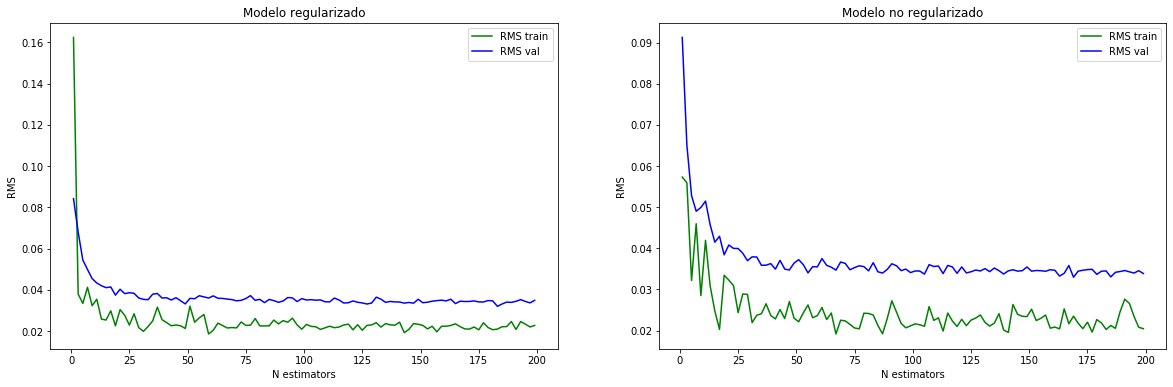

In [39]:
plt.figure(figsize=(20,6))

#Modelo regularizado
plt.subplot(121)
plt.plot(N_estimators, rmse_train_r, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val_r, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo regularizado')
plt.legend()

#Modelo no regularizado
plt.subplot(122)
plt.plot(N_estimators, rmse_train, c = 'green', label = 'RMS train')
plt.plot(N_estimators, rmse_val, c = 'blue', label = 'RMS val')
plt.xlabel("N estimators")
plt.ylabel("RMS")
plt.title('Modelo no regularizado')
plt.legend()

***comentar weas***.

> g) Verifique que el OOB error (out of bag error) de los ensambladores que utilizan la técnica boostrap puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto cross validation).

In [ ]:
oob_error = model.oob_score_
val_error = model.score(X_val,y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)